In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import Krylov as K
np.set_printoptions(precision=4)

We start by considering the spectral decomposition for an arbitrary matrix (with random elements)

In [2]:
n=50
Hr=np.matrix(np.random.rand(n*n).reshape(n,n))
Hi=np.matrix(np.random.rand(n*n).reshape(n,n))
H = Hr+1*1j*Hi
#H += H.H
u0 = np.matrix(np.random.rand(n).reshape(n,1))
u0norm = K.norm(u0)
u0=u0/u0norm
K.norm(u0)

0.99999999999999978

In [3]:
#H

We compute eigenvalues and left and right eigenvectors (all written as row vectors). Eigenvalues are sorted in decreasing order. We also check the meaning of the left and right eigenvalue conditions.

In [4]:
e,vr,vl = K.nonHermitian_eigensystem(H)
K.validate_eigensystem(H,e,vr)
K.validate_eigensystem(H.H,e.conj(),vl)

Validation terminated
Validation terminated


In [5]:
#print(e)

Right eigenvectors are normalized to 1

In [6]:
rnorm = np.zeros(n,dtype=np.complex_)
for i in range(n):
    rnorm[i] = K.sp(vr[:,i],vr[:,i])
idnorm = np.empty(n)
idnorm.fill(1)
print(np.allclose(rnorm,idnorm,atol=1.e-12))

True


The basis is bi-orthonormal in the sense that $\langle \chi_{n} | \phi_{m} \rangle = \delta_{nm}$

In [7]:
ind = np.arange(n)
M = np.matmul(vl[:,ind].H,vr[:,ind])
np.allclose(M,np.matrix(np.eye(n)),atol=1.e-12)

True

Using the left and right eigenvector we can write and check the completeness relation, that is:
$$
\sum_{n} | \phi_{n} \rangle \langle \chi_{n} | = 1
$$

In [8]:
Id=np.matrix(np.zeros((n*n),dtype=np.complex_).reshape(n,n))
for ind in range(n):
    Id += np.matmul(vr[:,ind],vl[:,ind].H)
np.allclose(Id,np.eye(n),atol=1.e-12)

True

We compute the resolvent of $H$ by using the spectral representation of $H$
$$ G(z) = \frac{1}{z-H}  = \sum_{n,m} | \phi_{n} \rangle \langle \chi_{n} | \frac{1}{z-H}| \phi_{m} \rangle \langle \chi_{m}| = \sum_{n}| \phi_{n} \rangle \langle \chi_{n}|\frac{1}{z-E_{n}}
$$
where $|\phi_{n}\rangle$ and $\langle \chi_{n}|$ are the right and left eigenvectors of $H$.

and we check the validity of the resolvent condition
$$G(z)(z-H)=1
$$

In [9]:
def Gcheck(omega,eta=1.e-2):
    G=np.matrix(np.zeros((n*n),dtype=np.complex_).reshape(n,n))
    for ind,E in enumerate(e):
        G += np.matmul(vr[:,ind],vl[:,ind].H)*1.0/(omega-E+1j*eta)
    zmH = (omega+1j*eta)*np.eye(n) - H
    GzmH = np.matmul(G,zmH)
    isok = np.allclose(GzmH,np.eye(n),atol=1.e-12)
    return isok

In [10]:
x=np.arange(-2.0, 2.0, 0.01)
for val in x: 
    if not Gcheck(val): print('False resolvent condition')
print('Gcheck Terminated')

Gcheck Terminated


Now I compute the resolvent of $H$ on $u_{0}$ by using the spectral representation of $H$
$$ G_{0}(z) = \langle u_{0} | \frac{1}{z-H} | u_{0} \rangle = \sum_{n}\frac{\langle u_{0} | \phi_{n} \rangle \langle \chi_{n}|u_{0}\rangle}{z-E_{n}}
$$
where $|\phi_{n}\rangle$ and $\langle \chi_{n}|$ are the right and left eigenvectors of $H$.

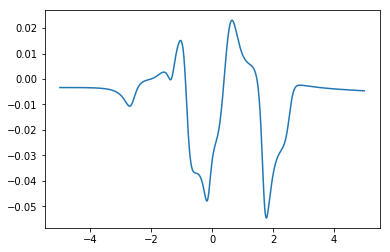

In [11]:
x=np.arange(-5.0, 5.0, 0.01)
plt.plot(x,K.resolvent_nonHermitian(u0,e,vr,vl,x))

Now we want to reproduce this result using the Lanczos procedure. We build the right and left Krylov spaces $|\phi_{j}\rangle, \langle \chi_{j}|$ generated by the repeated action of $H$ on the given (normalized) right and left vectors $|u_{0}\rangle, \langle u_{0}|$. We use the procedure described in the paper of Gruning. 

The procedure takes as input the values of $|\phi_{j}\rangle,|\phi_{j-1}\rangle,\langle\chi_{j}|,\langle\chi_{j-1}|,\alpha_{j},\beta_{j},\gamma_{j}$ and gives $|\phi_{j+1}\rangle,\langle\chi_{j+1}|,\alpha_{j+1},\beta_{j+1},\gamma_{j+1}$ built by the following operations:

$$
|\tilde\phi_{j+1}\rangle = (H-\alpha_{j})|\phi_{j}\rangle - \gamma_{j}|\phi_{j-1}\rangle \; , \qquad
\langle\tilde\chi_{j+1}| = \langle\chi_{j}|(H-\alpha_{j})  - \langle\chi_{j-1}|\beta_{j}
$$

$$
\beta_{j+1} = || \tilde\phi_{j+1} || \; , \quad 
\gamma_{j+1} = \frac{\langle\tilde\chi_{j+1}|\tilde\phi_{j+1}\rangle}{\beta_{j+1}} \; , \quad
|\phi_{j+1}\rangle = \frac{|\tilde\phi_{j+1}\rangle}{\beta_{j+1}} \; , \quad
\langle\chi_{j+1}| = \frac{\langle\tilde\chi_{j+1}|}{\gamma_{j+1}} \; , \quad
\alpha_{j+1} = \langle\chi_{j+1}|H|\phi_{j+1}\rangle
$$

The procedure is initialized as follows:

$$
|\phi_{0}\rangle = |u_{0}\rangle \; , \quad \langle \chi_{0}| = \langle u_{0}|  \; , \quad \alpha_{0} = \langle u_{0}|H|u_{0}\rangle \; , \quad \beta_{0} = \gamma_{0} = 0
$$

We perform the recursion until the Krylov space reaches a given dimension

In [12]:
dimKrylov = n+10
KL=K.KrylovLoop_nonHermitian(dimKrylov,H,u0)
KL.iterate()

Dimension Krylov space =  3 Orthogonality check =  True Tridiagonal check =  True
Dimension Krylov space =  4 Orthogonality check =  True Tridiagonal check =  True
Dimension Krylov space =  5 Orthogonality check =  True Tridiagonal check =  False
Dimension Krylov space =  6 Orthogonality check =  True Tridiagonal check =  False
Dimension Krylov space =  7 Orthogonality check =  False Tridiagonal check =  False
Dimension Krylov space =  8 Orthogonality check =  False Tridiagonal check =  False
Dimension Krylov space =  9 Orthogonality check =  False Tridiagonal check =  False
Dimension Krylov space =  10 Orthogonality check =  False Tridiagonal check =  False
Dimension Krylov space =  11 Orthogonality check =  False Tridiagonal check =  False
Dimension Krylov space =  12 Orthogonality check =  False Tridiagonal check =  False
Dimension Krylov space =  13 Orthogonality check =  False Tridiagonal check =  False
Dimension Krylov space =  14 Orthogonality check =  False Tridiagonal check = 

We compute the resolvent as a continued fraction

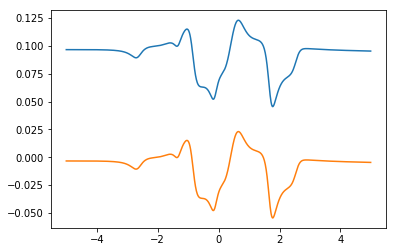

In [13]:
x=np.arange(-5.0, 5.0, 0.01)
plt.plot(x,0.1+K.resolvent_nonHermitian(u0,e,vr,vl,x))
plt.plot(x,K.Gfrac(KL.alpha,KL.beta,KL.gamma,x))
plt.show()

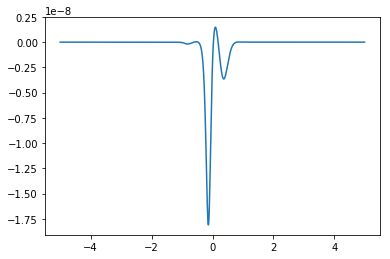

In [14]:
x=np.arange(-5.0, 5.0, 0.01)
plt.plot(x,K.resolvent_nonHermitian(u0,e,vr,vl,x)-K.Gfrac(KL.alpha,KL.beta,KL.gamma,x))
plt.show()